In [ ]:
#! -*- coding: utf-8 -*-

In [ ]:
%matplotlib inline

# GWpyによる信号処理パート1：周波数ドメイン

前回の復習（コードのみ）：

Fetched 1 URLs from https://losc.ligo.org for [1126259457 .. 1126259467)
Reading data... [Done]


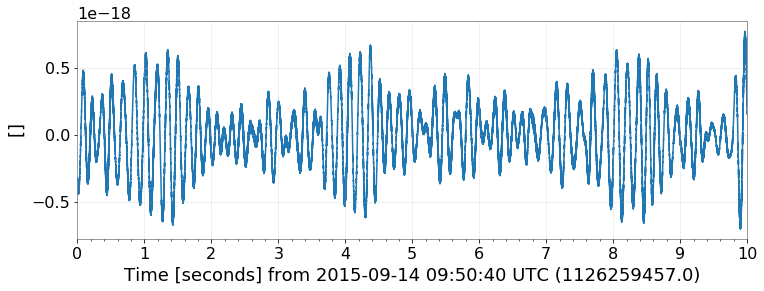

In [15]:
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries

gps = event_gps('GW150914')
igps = int(gps)
segment = (igps - 5, igps + 5)
hdata = TimeSeries.fetch_open_data('H1', *segment, verbose=True, cache=True)
plot = hdata.plot()

さて、このプロットを見てもは良くわかりません。重力波のシグナルが見えません。
従って、信号処理が非常に重要になり、これらのデータの解析に不可欠です。

## フーリエ変換を用いた周波数領域のデータ解析の学習

[フーリエ変換](https://en.wikipedia.org/wiki/Fourier_transform)は、時間領域の信号のどの周波数領域にパワーが」あり、どの周波数領域にパワーがないかを知るために広く使用されている数学的ツールです。

["fft()"](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.fft)　メソッドを使って、私たちの `TimeSeries`のフーリエ変換を計算することができます


In [2]:
fft = hdata.fft()
print(fft)

FrequencySeries([  2.83592039e-21 +0.00000000e+00j,
                  -1.72531983e-20 +9.11145513e-21j,
                   1.55498401e-20 -6.38067019e-21j, ...,
                  -1.14703105e-23 -7.91379034e-26j,
                  -1.15218693e-23 +8.39374538e-28j,
                  -1.15216273e-23 +0.00000000e+00j]
                unit: dimensionless,
                f0: 0.0 Hz,
                df: 0.1 Hz,
                epoch: 1126259457.0,
                name: Strain,
                channel: None,
                frequencies: None)


結果は、データの各周波数の振幅と位相を表す複素振幅を持つ[FrequencySeries](https://gwpy.github.io/docs/stable/spectrum/index.html) です。
`abs（）`を使って振幅を抽出し、それをプロットすることができます：

/opt/conda/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


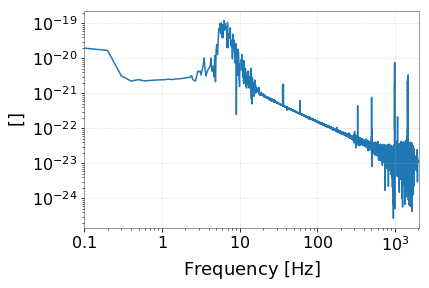

In [3]:
plot = fft.abs().plot(yscale = 'log')
plot.show()

これはまったく正しいとは思わない！
問題は、データが周期的であるという前提の下でFFTが機能することです。つまり、データのエッジが変換したときに不連続に見えることを意味します。
['scipy.signal'](https://docs.scipy.org/doc/scipy/reference/signal.html) モジュールを使用して変換する前に、時間領域のデータにウィンドウ関数を適用する必要があります。：

In [5]:
from scipy.signal import get_window
window = get_window('hann', hdata.size)
hwin = hdata * window

フーリエ変換をもう一度試み、何が得られるか、見てみましょう

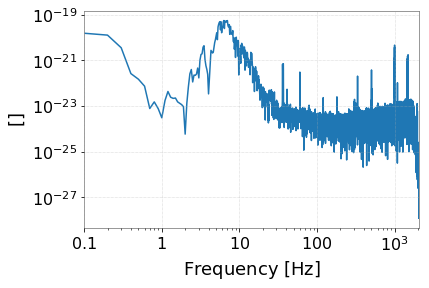

In [6]:
fftamp = hwin.fft().abs()
plot = fftamp.plot(yscale = 'log')
plot.show()

これが、重力波検出器の振幅スペクトル密度に期待されるようなシグナルです。

## パワースペクトル密度の計算

実際には、長期間のデータにわたって平均パワースペクトル密度を推定するために、通常、多数のFFTを使用します。
これを行うには、[`asd（）`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.asd) メソッドを使用します。 [Welch's method](https://en.wikipedia.org/wiki/Welch%27s_method)を使用して、重なり合ったウィンドウのチャンクのFFTを結合します。

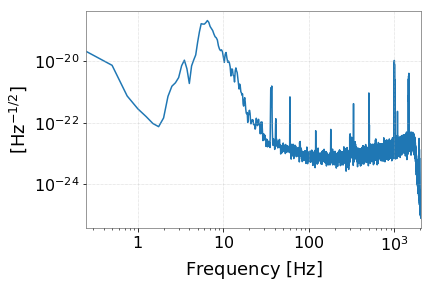

In [7]:
asd = hdata.asd(fftlength=4)
plot = asd.plot(yscale = 'log')
plot.show()

We can zoom in around the interesting frequency band:

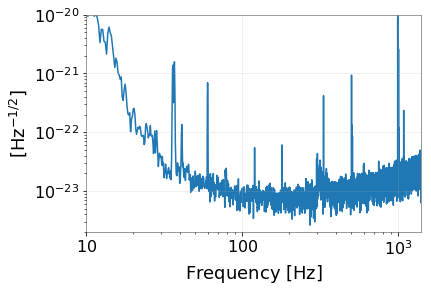

In [8]:
ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(2e-24, 1e-20)
plot

ASDは、重力波検出器の周波数領域感度を研究するために使用される標準的なツールです。
ロードしたLIGO-Hanfordデータの場合、特定の周波数で大きなスパイクが見られます。

- 35Hz
- 60,120,180Hz
- 320Hz
- 500Hz
- ...

losc.ligo.orgの[O1 spectral lines](https://losc.ligo.org/o1speclines/)ページには、これらのスペクトルの特徴のいくつかが記載されています。それらのいくつかは除去できないシグナルで、一部は干渉計の制御の為のシグナルです

より多くのデータをロードすると、ASD計算中にFFTを平均化することができます。つまり、ランダムなばらつきが平均化され、さらに詳細が表示されます。

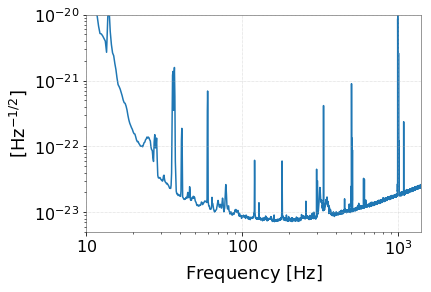

In [9]:
hdata2 = TimeSeries.fetch_open_data('H1', igps-512, igps+512, cache=True)
hasd2 = hdata2.asd(fftlength=4)
plot = hasd2.plot()
ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(5e-24, 1e-20)
plot.show()

これで、より多くの線（例：40 Hz）と320 Hz付近の大きな凹凸のあるフィーチャを明確に表示できます。
比較のために、LIGO-Livingstonのデータをロードし、それをプロットすることもできます：

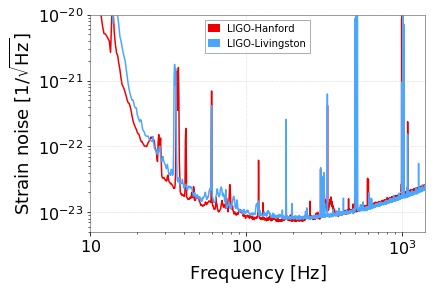

In [10]:
# get Livingston data
ldata2 = TimeSeries.fetch_open_data('L1', igps-512, igps+512, cache=True)
lasd2 = ldata2.asd(fftlength=4)

# and plot using standard colours
ax.plot(lasd2, label='LIGO-Livingston', color='gwpy:ligo-livingston')

# update the Hanford line to use standard colour, and have a label
hline = ax.lines[0]
hline.set_color('gwpy:ligo-hanford')  # change colour of Hanford data
hline.set_label('LIGO-Hanford')

ax.set_ylabel(r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]')
ax.legend()
plot

各LIGO計測器の相対的な感度、両者の共通の特徴、各観測所特有の感度を明確に見ることができます。

## FFTの時間発展を示す

FFTとASDは、信号の周波数ドメイン内容のスナップショットを一度に表示します。
この周波数ドメインのコンテンツがどのように時間とともに進化するかを示すことは、一般的に有用です。

このために、時間 - 周波数 - 振幅軸上の各時間ステップでのFFT（またはASD）を示すスペクトログラムを使用します。
GWpyの `TimeSeries`には2つのメソッドがあります：

- [`spectrogram()`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.spectrogram) - は各時間ステップでの平均ASDを示し、 
- [`spectrogram2()`](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.spectrogram2) - 各時間ステップで単一FFT ASDを表示する

どちらを使うべきですか？短い答えは、短い分（ish）のデータを1分以下で使用する `spectrogram2（）`と、平均化が非常に短いノイズバーストを除去するのに役立つより長いチャンクのための `spectrogram（）`です。

したがって、特定のFFT長（ウィンドウを使用することを忘れないでください）を使用してスペクトログラムを生成することができます：

<div class="alert alert-info">
これらの方法は、積分されたパワースペクトル密度をと出力として返します。したがって、平方根をとれば、よく知られている振幅スペクトル密度に変換できます。
</div>

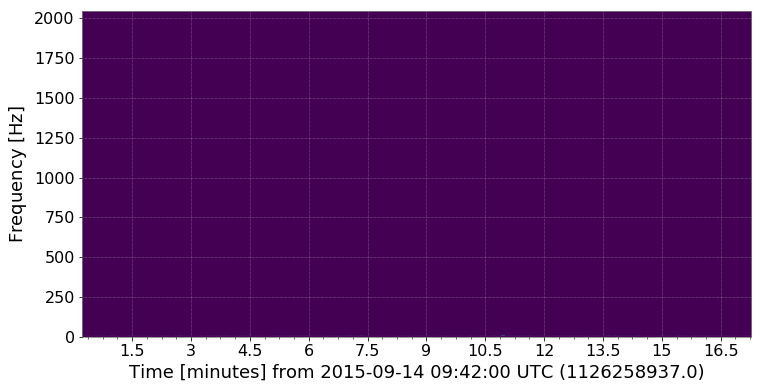

In [11]:
specgram = hdata2.spectrogram2(fftlength=4, overlap=2, window='hann') ** (1/2.)
plot = specgram.plot()
plot.show()

うーん...何かが正しくない。ディスプレイ（特に色付け）を制御するプロットにいくつかの引数を渡す必要があります。

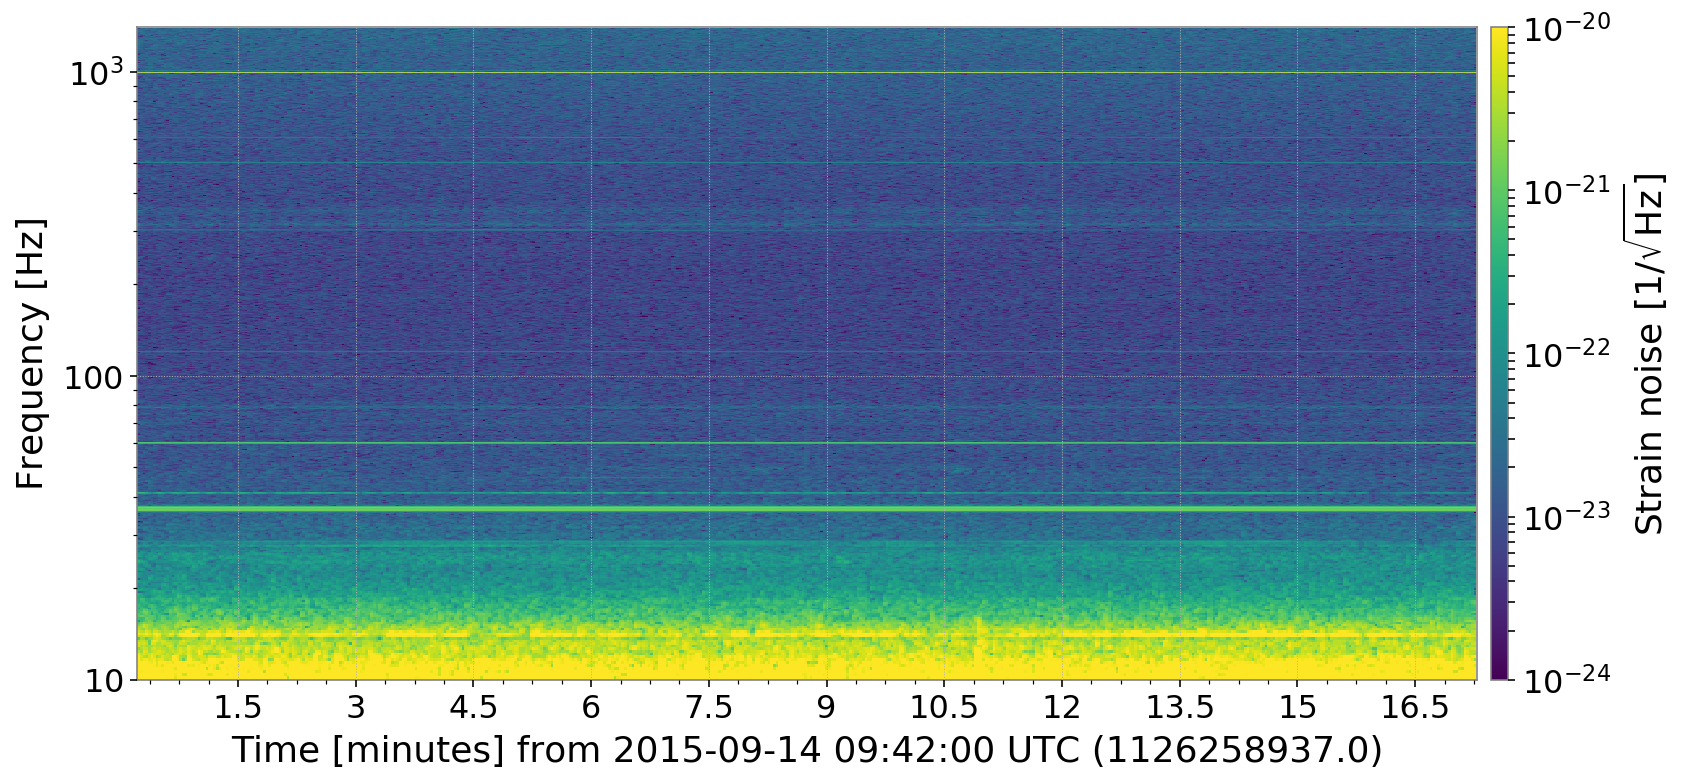

In [42]:
plot = specgram.plot(vmin=1e-24, vmax=1e-20, norm='log')
ax = plot.gca()
ax.set_yscale('log')
ax.set_ylim(10, 1400)
plot.add_colorbar(label=r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]')

## チャレンジタイム！

-  GW170814検出に関連する3つの検出器すべてのデータをダウンロードし、それぞれのPSDを生成し、プロットを作成する
-  LIGO-Livingston検出器のGW170817検出前後の10分間のスペクトログラムの作成する


Fetched 1 URLs from https://losc.ligo.org for [1186741856 .. 1186741866)
Reading data... [Done]
Fetched 1 URLs from https://losc.ligo.org for [1186741856 .. 1186741866)
Reading data... [Done]
Fetched 1 URLs from https://losc.ligo.org for [1186741856 .. 1186741866)
Reading data... [Done]


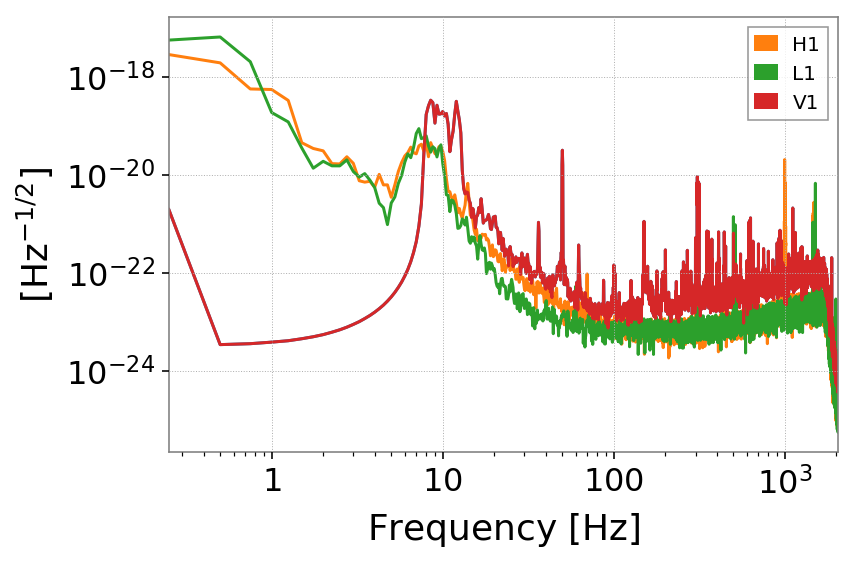

In [48]:
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries
gps = event_gps('GW170814')
igps = int(gps)
segment = (int(gps) - 5, int(gps) + 5)
hdata1 = TimeSeries.fetch_open_data('H1', *segment, verbose=True, cache=True, tag='CLN')
hdata2 = TimeSeries.fetch_open_data('L1', *segment, verbose=True, cache=True, tag='CLN')
hdata3 = TimeSeries.fetch_open_data('V1', *segment, verbose=True, cache=True, tag='CLN')

hasd1 = hdata1.asd(fftlength=4)
hasd2 = hdata2.asd(fftlength=4)
hasd3 = hdata3.asd(fftlength=4)

plot = hasd1.plot(yscale = 'log')
plot = hasd2.plot(yscale = 'log')
plot = hasd3.plot(yscale = 'log')

ax = plot.gca()
ax.plot(hasd1, label='H1')
ax.plot(hasd2, label='L1')
ax.plot(hasd3, label='V1')
ax.legend()


Fetched 1 URLs from https://losc.ligo.org for [1187008482 .. 1187009082)
Reading data... [Done]


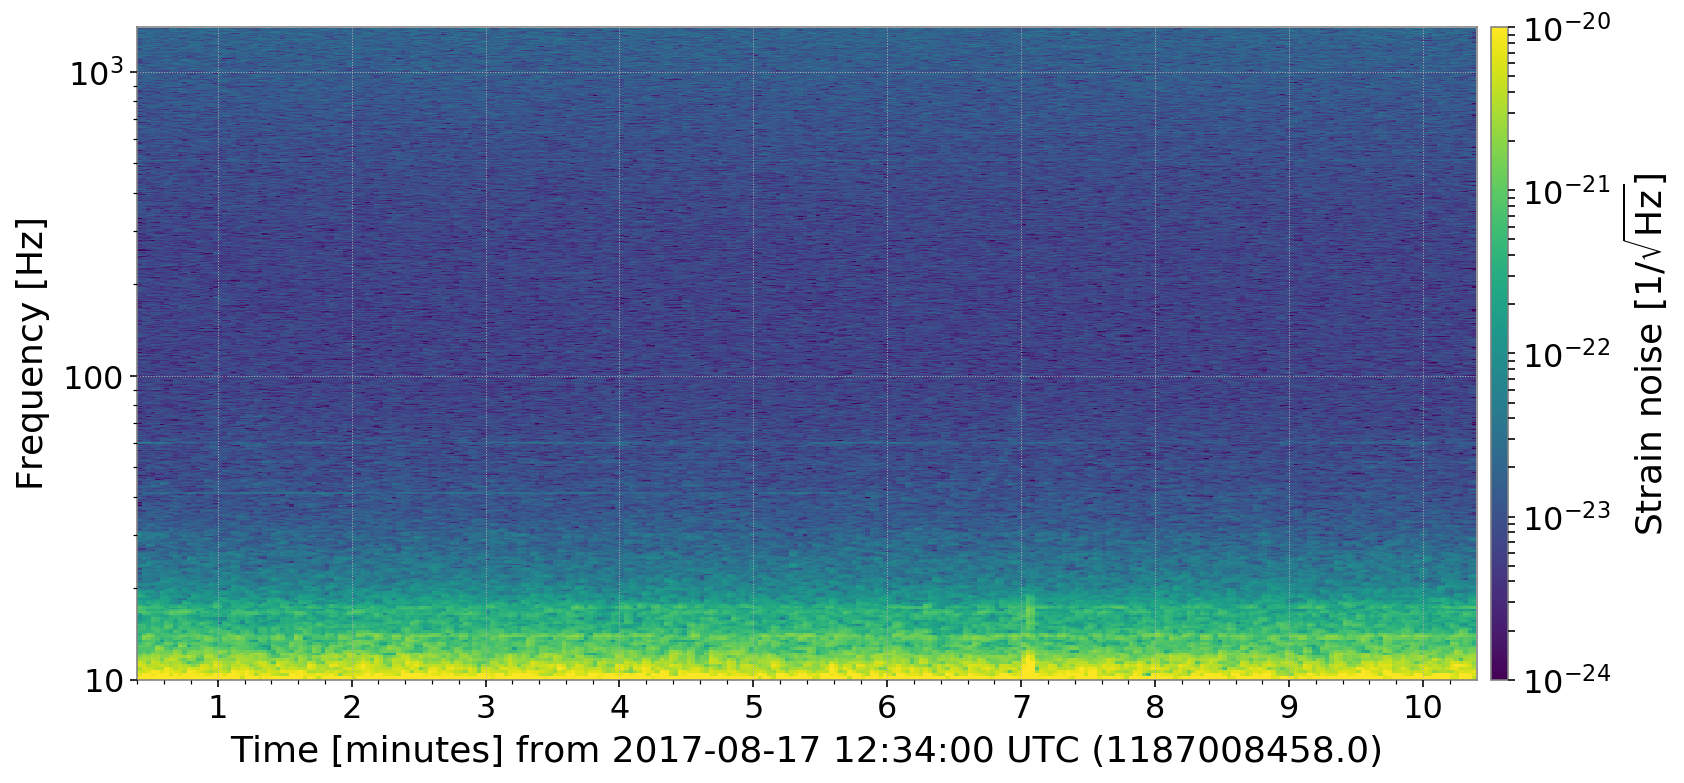

In [55]:
from gwosc.datasets import event_gps
from gwpy.timeseries import TimeSeries
gps = event_gps('GW170817')
igps = int(gps)
segment = (int(gps) - 400, int(gps) + 200)
ldata = TimeSeries.fetch_open_data('L1', *segment, verbose=True, cache=True, tag='CLN')
plot = ldata.plot()

specgram = ldata.spectrogram2(fftlength=4, overlap=2, window='hann') ** (1/2.)
plot = specgram.plot(vmin=1e-24, vmax=1e-20, norm='log')
ay = plot.gca()
ay.set_yscale('log')
ay.set_ylim(10, 1400)
plot.add_colorbar(label=r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]')
plot.show()